# Dataset




In [2]:
# Libaries for dataset subchapter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the dataset

In [4]:
#setting the temperature data as the dataframe
df = pd.read_excel('../data/temperature.xlsx')

In [24]:
# remove the first row, rename the first column and remove the last 4 columns
column = 'Date'
df = df.drop(0)
df = df.reset_index(drop=True)
df.rename(columns={'Unnamed: 0': column}, inplace=True)  # replace 'Date' with your preferred column name
df = df.drop(columns=['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'])
df[column] = pd.to_datetime(df[column])

for col in df.columns:
    if col != column:
        df[col] = pd.to_numeric(df[col], errors='coerce')

## Exploratory Data Analysis

In [ ]:
df.head()

In [ ]:
# Count of non-NaN values in each column
non_nan_count = df.count()

# Percentage of non-NaN values
percentage_non_nan = (non_nan_count / len(df)) * 100


# Count of missing values in each column
missing_data = df.isna().sum()
percentage_nan= (missing_data / len(df)) * 100

# Create a DataFrame from the non-NaN count and percentage
summary_df = pd.DataFrame({
    'Count of NaN values': missing_data,
    'Percentage of NaN values': percentage_nan,
    'Count of non-NaN values': non_nan_count,
    'Percentage of non-NaN values': percentage_non_nan

})

# Print the DataFrame
summary_df

In [ ]:
df.describe()

In [ ]:
# Adjust the default font size settings
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

In [ ]:
# Visualize the missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.show()

In [ ]:
# Drop non-temperature columns
temperature_columns = df.drop(columns=['Date'])

# Creates a list of lists, where each inner list contains the non-NaN values for each column
valid_values = [col_data.dropna().values for col_name, col_data in temperature_columns.items()]

# Create a boxplot for the temperature columns
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])

# Plot boxplot with valid values, setting labels to temperature column names
bp = ax.boxplot(valid_values, labels=temperature_columns.columns, widths=0.9)

plt.show()


# Data Preprocessing


In [25]:
# Libaries for data preprocessing subchapter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Executing some feature engineering based on the Date column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Weekday'] = df['Date'].dt.weekday
df['DayOfYear'] = df['Date'].dt.dayofyear
df['IsWeekend'] = df['Date'].dt.weekday // 5  # Returns 1 for Saturday and Sunday, and 0 for the rest of the days

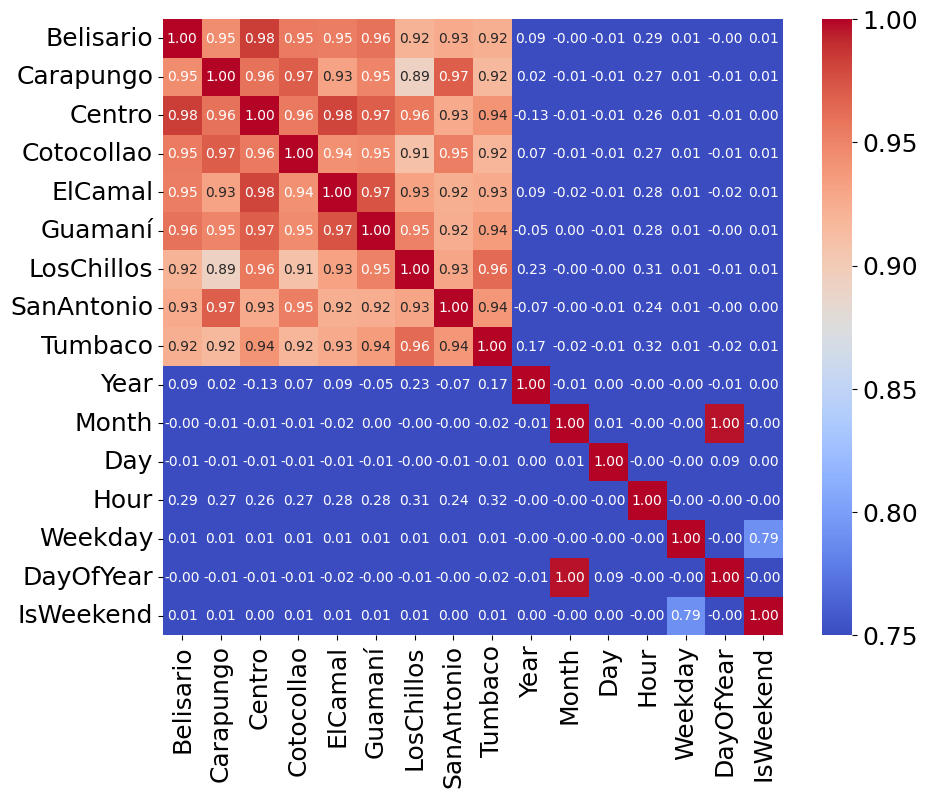

In [27]:
# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Adjust the default font size settings
plt.rcParams['font.size'] = 10

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=0.75, vmax=1)
plt.show()

# Adjust the default font size settings back again to the original
plt.rcParams['font.size'] = 16

In [28]:
# Define columns to be removed
columns_to_remove = ['Date', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'DayOfYear', 'IsWeekend']

# Remove unnecessary columns
df_model = df.drop(columns=columns_to_remove)

# Print the first row to verify
print("Initial data:\n", df_model.head(1))

# Show the number of NaNs in each column to confirm
print("\nCount of NaNs in each column:\n", df_model.isnull().sum())

# Perform normalization
df_model = -1 + 2 * (df_model - df_model.min()) / (df_model.max() - df_model.min())

# Print the first row of standardized data to verify
print("\nStandardized data:\n", df_model.head(1))

Initial data:
    Belisario  Carapungo  Centro  Cotocollao  ElCamal  Guamaní  LosChillos  \
0       9.93      12.73     NaN       10.41    12.57      NaN        9.95   

   SanAntonio  Tumbaco  
0         NaN    12.36  

Count of NaNs in each column:
 Belisario       2105
Carapungo       4347
Centro        131173
Cotocollao      3922
ElCamal        22284
Guamaní       115189
LosChillos      1589
SanAntonio    116469
Tumbaco         2165
dtype: int64

Standardized data:
    Belisario  Carapungo  Centro  Cotocollao   ElCamal  Guamaní  LosChillos  \
0  -0.469841  -0.321359     NaN   -0.189705 -0.140688      NaN   -0.265537   

   SanAntonio   Tumbaco  
0         NaN -0.178699  


In [29]:
temp_df = df_model[df_model.isna().any(axis=1)]
total_cells = np.product(temp_df.shape)
missing_cells = temp_df.isna().sum().sum()

percentage_missing = (missing_cells / total_cells)
print('Percentage of NaN in whole dataset:', (df_model.isna().sum().sum()) / (np.product(df_model.shape)))
print('Percentage of NaN in dataset (only containing incomplete rows):', percentage_missing)

Percentage of NaN in whole dataset: 0.26514807376591915
Percentage of NaN in dataset (only containing incomplete rows): 0.3278131666198647


# Data Mining Model

In [30]:
# Libaries for Data Mining Model subchapter
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as ticker

## AutoEncoder Model

In [31]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=9):
        super(AutoEncoder, self).__init__()

        # Encoder layers
        self.encoder_hidden_layer = nn.Linear(in_features=input_dim, out_features=3)
        self.encoder_output_layer = nn.Linear(in_features=3, out_features=2)

        # Decoder layers
        self.decoder_hidden_layer = nn.Linear(in_features=2, out_features=3)
        self.decoder_output_layer = nn.Linear(in_features=3, out_features=input_dim)

    def forward(self, features):
        # Encoder steps
        activation = torch.tanh(self.encoder_hidden_layer(features))
        code = torch.tanh(self.encoder_output_layer(activation))

        # Decoder steps
        activation = torch.tanh(self.decoder_hidden_layer(code))
        reconstructed = self.decoder_output_layer(activation)
        return reconstructed

print(AutoEncoder())

AutoEncoder(
  (encoder_hidden_layer): Linear(in_features=9, out_features=3, bias=True)
  (encoder_output_layer): Linear(in_features=3, out_features=2, bias=True)
  (decoder_hidden_layer): Linear(in_features=2, out_features=3, bias=True)
  (decoder_output_layer): Linear(in_features=3, out_features=9, bias=True)
)


## Training and Testing the model

In [32]:
# Remove rows with missing values
complete_data = df_model.dropna()

# Remove rows with missing values and convert DataFrame to PyTorch tensors
tensor_data = torch.tensor(complete_data.values, dtype=torch.float32)

# Create TensorDataset
tensor_dataset = TensorDataset(tensor_data)

In [33]:
def add_missingness(data, complete_data, missingness_factor=0.33):
    # Create a mask with random elements, using the specified missingness factor
    missing_mask = torch.bernoulli(torch.full(data.shape, missingness_factor)).bool()

    # Ensure that at least one element in the entire tensor is masked
    if not missing_mask.any():
        random_idx = torch.randint(0, data.numel(), (1,))
        missing_mask.view(-1)[random_idx] = True

    # Ensure that in every row, at least one value is present
    all_masked_rows = missing_mask.all(dim=1)
    for row in range(data.shape[0]):
        if all_masked_rows[row]:
            random_col = torch.randint(0, data.shape[1], (1,))
            missing_mask[row, random_col] = False

    # We'll use these tensors for in-place operations
    data_with_zeros = data.clone().float()
    data_with_meanOfRow = data.clone().float()
    data_with_medianOfRow = data.clone().float()
    data_with_meanOfColumn = data.clone().float()
    data_with_medianOfColumn = data.clone().float()
    data_with_randomInsertFromColumn = data.clone().float()
    data_with_distributionInsertFromColumn = data.clone().float()

    data_with_zeros[missing_mask] = 0

    row_indices, col_indices = torch.where(missing_mask)
    for row_idx, col_idx in zip(row_indices, col_indices):
        # Operations for row-based methods
        valid_data_row = data[row_idx][~missing_mask[row_idx]]

        mean_value_row = valid_data_row.mean().item()
        median_value_row = valid_data_row.median().item()

        data_with_meanOfRow[row_idx, col_idx] = mean_value_row
        data_with_medianOfRow[row_idx, col_idx] = median_value_row

        # Operations for column-based methods
        column_data = complete_data.iloc[:, col_idx.item()].to_numpy()

        mean_value_col = column_data.mean()
        median_value_col = np.median(column_data)
        std_value_col = column_data.std()

        data_with_meanOfColumn[row_idx, col_idx] = mean_value_col
        data_with_medianOfColumn[row_idx, col_idx] = median_value_col

        random_value_col = np.random.choice(column_data)
        data_with_randomInsertFromColumn[row_idx, col_idx] = random_value_col

        distribution_value = np.random.normal(mean_value_col, std_value_col)
        data_with_distributionInsertFromColumn[row_idx, col_idx] = distribution_value

    return (data_with_meanOfRow, data_with_medianOfRow, data_with_zeros, missing_mask,
            data_with_randomInsertFromColumn, data_with_distributionInsertFromColumn,
            data_with_meanOfColumn, data_with_medianOfColumn)

# RMSE
def rmse(predictions, targets):
    return torch.sqrt(((predictions - targets) ** 2).mean())

In [37]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 5
train_losses = []

# Train information
train_losses = []
train_mean_losses = []
train_median_losses = []
train_randomInsertFromColumn_losses = []
train_distributionInsertFromColumn_losses = []
train_meanOfColumn_losses = []
train_medianOfColumn_losses = []

# Placeholder for evaluation metrics
train_rmse_losses = []
train_mean_rmse_losses = []
train_median_rmse_losses = []
train_randomInsertFromColumn_rmse_losses = []
train_distributionInsertFromColumn_rmse_losses = []
train_meanOfColumn_rmse_losses = []
train_medianOfColumn_rmse_losses = []

# Test information
test_losses = []
test_mean_losses = []
test_median_losses = []
test_randomInsertFromColumn_losses = []
test_distributionInsertFromColumn_losses = []
test_meanOfColumn_losses = []
test_medianOfColumn_losses = []

# Placeholder for evaluation metrics
test_rmse_losses = []
test_mean_rmse_losses = []
test_median_rmse_losses = []
test_randomInsertFromColumn_rmse_losses = []
test_distributionInsertFromColumn_rmse_losses = []
test_meanOfColumn_rmse_losses = []
test_medianOfColumn_rmse_losses = []

# Create K-Fold Setup
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the k-fold cross-validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(tensor_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Prepare train and test sets based on current fold
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    train_loader = DataLoader(dataset=tensor_dataset, batch_size=24, sampler=train_subsampler)
    test_loader = DataLoader(dataset=tensor_dataset, batch_size=24, sampler=test_subsampler)

    for epoch in range(num_epochs):
        train_mean_predictions = []
        train_median_predictions = []
        train_randomInsertFromColumn_predictions = []
        train_distributionInsertFromColumn_predictions = []
        train_meanOfColumn_predictions = []
        train_medianOfColumn_predictions = []
        train_autoencoder_predictions = []
        train_actuals = []

        model.train()
        train_loss = 0.0
        train_loss_for_mean = 0.0
        train_loss_for_median = 0.0
        train_loss_for_randomInsertFromColumn = 0.0
        train_loss_for_distributionInsertFromColumn = 0.0
        train_loss_for_meanOfColumn = 0.0
        train_loss_for_medianOfColumn = 0.0
        # Training Phase
        for batch_features in train_loader:
                # Add "missingness" to the input data
                data_with_mean, data_with_median, data_with_zeros, missing_mask, data_with_randomInsertFromColumn, data_with_distributionInsertFromColumn, data_with_meanOfColumn, data_with_medianOfColumn = add_missingness(batch_features[0], complete_data)

                # Forward pass
                outputs = model(data_with_zeros)

                # Compute loss only for non-missing values
                model_pred = outputs[missing_mask]
                actual_data = batch_features[0][missing_mask]
                mean_data = data_with_mean[missing_mask]
                median_data = data_with_median[missing_mask]
                randomInsertFromColumn_data = data_with_randomInsertFromColumn[missing_mask]
                distributionInsertFromColumn_data = data_with_distributionInsertFromColumn[missing_mask]
                meanOfColumn_data = data_with_meanOfColumn[missing_mask]
                medianOfColumn_data = data_with_medianOfColumn[missing_mask]

                # compute the loss for the different methods
                loss_model = criterion(model_pred, actual_data)
                loss_mean = criterion(mean_data, actual_data)
                loss_median = criterion(median_data, actual_data)
                loss_randomInsertFromColumn = criterion(randomInsertFromColumn_data, actual_data)
                loss_distributionInsertFromColumn = criterion(distributionInsertFromColumn_data, actual_data)
                loss_meanOfColumn = criterion(meanOfColumn_data, actual_data)
                loss_medianOfColumn = criterion(medianOfColumn_data, actual_data)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss_model.backward()
                optimizer.step()

                train_loss += loss_model.item()
                train_loss_for_mean += loss_mean.item()
                train_loss_for_median += loss_median.item()
                train_loss_for_randomInsertFromColumn += loss_randomInsertFromColumn.item()
                train_loss_for_distributionInsertFromColumn += loss_distributionInsertFromColumn.item()
                train_loss_for_meanOfColumn += loss_meanOfColumn.item()
                train_loss_for_medianOfColumn += loss_medianOfColumn.item()

                train_mean_predictions.extend(mean_data)
                train_median_predictions.extend(median_data)
                train_randomInsertFromColumn_predictions.extend(randomInsertFromColumn_data)
                train_distributionInsertFromColumn_predictions.extend(distributionInsertFromColumn_data)
                train_meanOfColumn_predictions.extend(meanOfColumn_data)
                train_medianOfColumn_predictions.extend(medianOfColumn_data)
                train_autoencoder_predictions.extend(model_pred)
                train_actuals.extend(actual_data)



        # Calculate RMSE for the entire train set after the loop
        rmse_score_autoencoder = rmse(torch.tensor(train_autoencoder_predictions), torch.tensor(train_actuals))
        rmse_score_mean = rmse(torch.tensor(train_mean_predictions), torch.tensor(train_actuals))
        rmse_score_median = rmse(torch.tensor(train_median_predictions), torch.tensor(train_actuals))
        rmse_score_randomInsertFromColumn = rmse(torch.tensor(train_randomInsertFromColumn_predictions), torch.tensor(train_actuals))
        rmse_score_distributionInsertFromColumn = rmse(torch.tensor(train_distributionInsertFromColumn_predictions), torch.tensor(train_actuals))
        rmse_score_meanOfColumn = rmse(torch.tensor(train_meanOfColumn_predictions), torch.tensor(train_actuals))
        rmse_score_medianOfColumn = rmse(torch.tensor(train_medianOfColumn_predictions), torch.tensor(train_actuals))

        # Convert the total train loss to average train loss
        train_loss = train_loss / len(train_loader)
        train_loss_for_mean = train_loss_for_mean / len(train_loader)
        train_loss_for_median = train_loss_for_median / len(train_loader)
        train_loss_for_randomInsertFromColumn = train_loss_for_randomInsertFromColumn / len(train_loader)
        train_loss_for_distributionInsertFromColumn = train_loss_for_distributionInsertFromColumn / len(train_loader)
        train_loss_for_meanOfColumn = train_loss_for_meanOfColumn / len(train_loader)
        train_loss_for_medianOfColumn = train_loss_for_medianOfColumn / len(train_loader)

        train_losses.append(train_loss)
        train_mean_losses.append(train_loss_for_mean)
        train_median_losses.append(train_loss_for_median)
        train_randomInsertFromColumn_losses.append(train_loss_for_randomInsertFromColumn)
        train_distributionInsertFromColumn_losses.append(train_loss_for_distributionInsertFromColumn)
        train_meanOfColumn_losses.append(train_loss_for_meanOfColumn)
        train_medianOfColumn_losses.append(train_loss_for_medianOfColumn)

        train_rmse_losses.append(rmse_score_autoencoder.item())
        train_mean_rmse_losses.append(rmse_score_mean.item())
        train_median_rmse_losses.append(rmse_score_median.item())
        train_randomInsertFromColumn_rmse_losses.append(rmse_score_randomInsertFromColumn.item())
        train_distributionInsertFromColumn_rmse_losses.append(rmse_score_distributionInsertFromColumn.item())
        train_meanOfColumn_rmse_losses.append(rmse_score_meanOfColumn.item())
        train_medianOfColumn_rmse_losses.append(rmse_score_medianOfColumn.item())

        # Placeholder for predictions and actual values
        all_mean_predictions = []
        all_median_predictions = []
        all_randomInsertFromColumn_predictions = []
        all_distributionInsertFromColumn_predictions = []
        all_meanOfColumn_predictions = []
        all_medianOfColumn_predictions = []
        all_autoencoder_predictions = []
        all_actuals = []

        # Test Phase
        model.eval()  # set the model to evaluation mode
        test_loss = 0.0
        test_loss_for_mean = 0.0
        test_loss_for_median = 0.0
        test_loss_for_randomInsertFromColumn = 0.0
        test_loss_for_distributionInsertFromColumn = 0.0
        test_loss_for_meanOfColumn = 0.0
        test_loss_for_medianOfColumn = 0.0
        with torch.no_grad():  # to save memory during inference
            for batch_features in test_loader:
                data_with_mean, data_with_median, data_with_zeros, missing_mask, data_with_randomInsertFromColumn, data_with_distributionInsertFromColumn, data_with_meanOfColumn, data_with_medianOfColumn = add_missingness(batch_features[0], complete_data)
                outputs = model(data_with_zeros)

                mean_data = data_with_mean[missing_mask]
                median_data = data_with_median[missing_mask]
                randomInsertFromColumn_data = data_with_randomInsertFromColumn[missing_mask]
                distributionInsertFromColumn_data = data_with_distributionInsertFromColumn[missing_mask]
                meanOfColumn_data = data_with_meanOfColumn[missing_mask]
                medianOfColumn_data = data_with_medianOfColumn[missing_mask]
                model_pred = outputs[missing_mask]
                actual_data = batch_features[0][missing_mask]

                loss_model = criterion(model_pred, actual_data)
                loss_mean = criterion(mean_data, actual_data)
                loss_median = criterion(median_data, actual_data)
                loss_randomInsertFromColumn = criterion(randomInsertFromColumn_data, actual_data)
                loss_distributionInsertFromColumn = criterion(distributionInsertFromColumn_data, actual_data)
                loss_meanOfColumn = criterion(meanOfColumn_data, actual_data)
                loss_medianOfColumn = criterion(medianOfColumn_data, actual_data)

                test_loss += loss_model.item()
                test_loss_for_mean += loss_mean.item()
                test_loss_for_median += loss_median.item()
                test_loss_for_randomInsertFromColumn += loss_randomInsertFromColumn.item()
                test_loss_for_distributionInsertFromColumn += loss_distributionInsertFromColumn.item()
                test_loss_for_meanOfColumn += loss_meanOfColumn.item()
                test_loss_for_medianOfColumn += loss_medianOfColumn.item()

                all_mean_predictions.extend(mean_data)
                all_median_predictions.extend(median_data)
                all_randomInsertFromColumn_predictions.extend(randomInsertFromColumn_data)
                all_distributionInsertFromColumn_predictions.extend(distributionInsertFromColumn_data)
                all_meanOfColumn_predictions.extend(meanOfColumn_data)
                all_medianOfColumn_predictions.extend(medianOfColumn_data)
                all_autoencoder_predictions.extend(model_pred)
                all_actuals.extend(actual_data)

        # Calculate RMSE for the entire test set after the loop
        rmse_score_autoencoder = rmse(torch.tensor(all_autoencoder_predictions), torch.tensor(all_actuals))
        rmse_score_mean = rmse(torch.tensor(all_mean_predictions), torch.tensor(all_actuals))
        rmse_score_median = rmse(torch.tensor(all_median_predictions), torch.tensor(all_actuals))
        rmse_score_randomInsertFromColumn = rmse(torch.tensor(all_randomInsertFromColumn_predictions), torch.tensor(all_actuals))
        rmse_score_distributionInsertFromColumn = rmse(torch.tensor(all_distributionInsertFromColumn_predictions), torch.tensor(all_actuals))
        rmse_score_meanOfColumn = rmse(torch.tensor(all_meanOfColumn_predictions), torch.tensor(all_actuals))
        rmse_score_medianOfColumn = rmse(torch.tensor(all_medianOfColumn_predictions), torch.tensor(all_actuals))

        # Convert the total test loss to average test loss
        test_loss = test_loss / len(test_loader)
        test_loss_for_mean = test_loss_for_mean / len(test_loader)
        test_loss_for_median = test_loss_for_median / len(test_loader)
        test_loss_for_randomInsertFromColumn = test_loss_for_randomInsertFromColumn / len(test_loader)
        test_loss_for_distributionInsertFromColumn = test_loss_for_distributionInsertFromColumn / len(test_loader)
        test_loss_for_meanOfColumn = test_loss_for_meanOfColumn / len(test_loader)
        test_loss_for_medianOfColumn = test_loss_for_medianOfColumn / len(test_loader)

        test_losses.append(test_loss)
        test_mean_losses.append(test_loss_for_mean)
        test_median_losses.append(test_loss_for_median)
        test_randomInsertFromColumn_losses.append(test_loss_for_randomInsertFromColumn)
        test_distributionInsertFromColumn_losses.append(test_loss_for_distributionInsertFromColumn)
        test_meanOfColumn_losses.append(test_loss_for_meanOfColumn)
        test_medianOfColumn_losses.append(test_loss_for_medianOfColumn)

        test_rmse_losses.append(rmse_score_autoencoder.item())
        test_mean_rmse_losses.append(rmse_score_mean.item())
        test_median_rmse_losses.append(rmse_score_median.item())
        test_randomInsertFromColumn_rmse_losses.append(rmse_score_randomInsertFromColumn.item())
        test_distributionInsertFromColumn_rmse_losses.append(rmse_score_distributionInsertFromColumn.item())
        test_meanOfColumn_rmse_losses.append(rmse_score_meanOfColumn.item())
        test_medianOfColumn_rmse_losses.append(rmse_score_medianOfColumn.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

FOLD 0
--------------------------------
Epoch 1/5, Train Loss: 0.0293, Test Loss: 0.0099
Epoch 2/5, Train Loss: 0.0096, Test Loss: 0.0096
Epoch 3/5, Train Loss: 0.0097, Test Loss: 0.0094
Epoch 4/5, Train Loss: 0.0095, Test Loss: 0.0094
Epoch 5/5, Train Loss: 0.0092, Test Loss: 0.0095
FOLD 1
--------------------------------
Epoch 1/5, Train Loss: 0.0092, Test Loss: 0.0090
Epoch 2/5, Train Loss: 0.0089, Test Loss: 0.0091
Epoch 3/5, Train Loss: 0.0090, Test Loss: 0.0090
Epoch 4/5, Train Loss: 0.0091, Test Loss: 0.0091
Epoch 5/5, Train Loss: 0.0088, Test Loss: 0.0087
FOLD 2
--------------------------------
Epoch 1/5, Train Loss: 0.0089, Test Loss: 0.0092
Epoch 2/5, Train Loss: 0.0088, Test Loss: 0.0086
Epoch 3/5, Train Loss: 0.0087, Test Loss: 0.0092
Epoch 4/5, Train Loss: 0.0089, Test Loss: 0.0088
Epoch 5/5, Train Loss: 0.0087, Test Loss: 0.0094
FOLD 3
--------------------------------
Epoch 1/5, Train Loss: 0.0088, Test Loss: 0.0086
Epoch 2/5, Train Loss: 0.0087, Test Loss: 0.0081
Epoch 3

## Plotting the results of Training and Testing

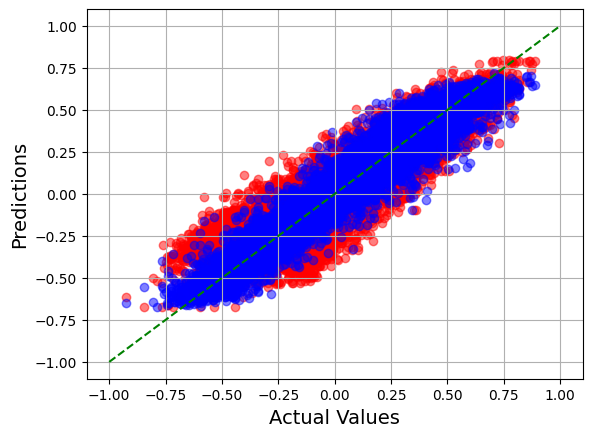

In [38]:
# Adjust the default font size settings
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 12

# Converting to numpy arrays for easier manipulation in plotting
all_mean_predictions = np.array(all_mean_predictions)
all_autoencoder_predictions = np.array(all_autoencoder_predictions)
all_actuals = np.array(all_actuals)

# Create a scatter plot
plt.scatter(all_actuals, all_mean_predictions, color='red', alpha=0.5)
plt.scatter(all_actuals, all_autoencoder_predictions, color='blue', alpha=0.5)
plt.plot([-1.0, 1.0], [-1.0, 1.0], color='green', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

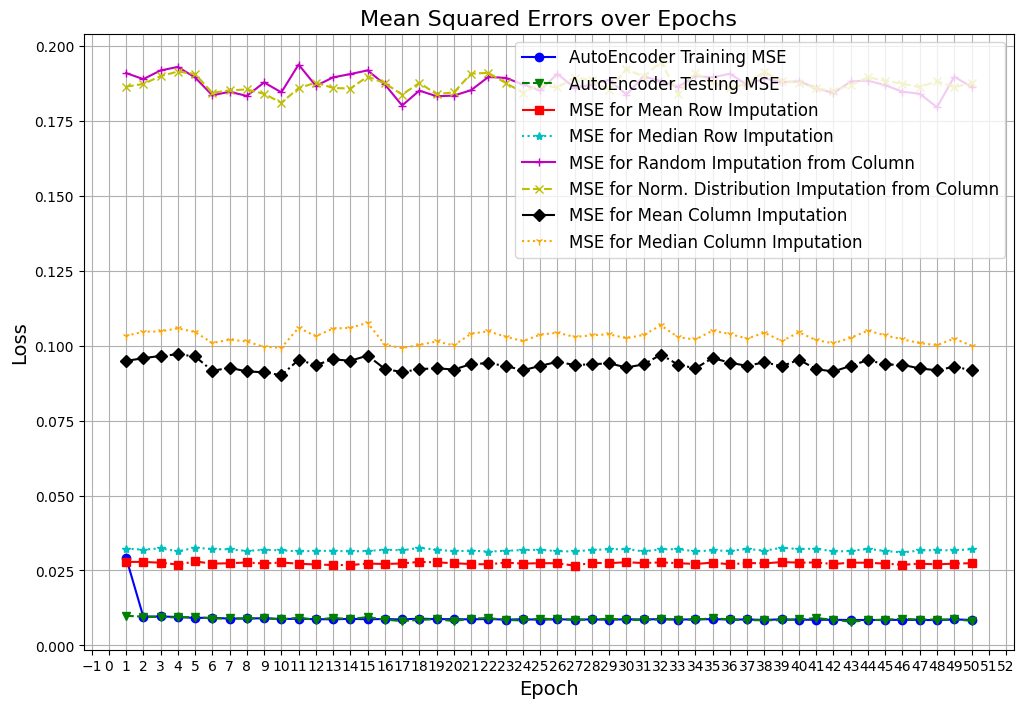

In [39]:
plt.figure(figsize=(12, 8))

# Define a color and linestyle for each plot for better differentiation
styles = ['-', '--', '-.', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
markers = ['o', 'v', 's', '*', '+', 'x', 'D', '1'] # Ensure you have as many markers as lines

lines = []
labels = [
    'AutoEncoder Training MSE',
    'AutoEncoder Testing MSE',
    'MSE for Mean Row Imputation',
    'MSE for Median Row Imputation',
    'MSE for Random Imputation from Column',
    'MSE for Norm. Distribution Imputation from Column',
    'MSE for Mean Column Imputation',
    'MSE for Median Column Imputation'
]

losses = [
    train_losses,
    test_losses,
    test_mean_losses,
    test_median_losses,
    test_randomInsertFromColumn_losses,
    test_distributionInsertFromColumn_losses,
    test_meanOfColumn_losses,
    test_medianOfColumn_losses
]

for i, loss in enumerate(losses):
    epochs_shifted = range(1, len(loss) + 1)
    line, = plt.plot(epochs_shifted, loss, linestyle=styles[i % len(styles)], color=colors[i % len(colors)], marker=markers[i % len(markers)])
    lines.append(line)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Mean Squared Errors over Epochs')
plt.legend(lines, labels, loc='upper right')


# Set the x-axis major ticks to an interval of 1
locator = ticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(locator)

plt.grid(visible=True)

plt.show()

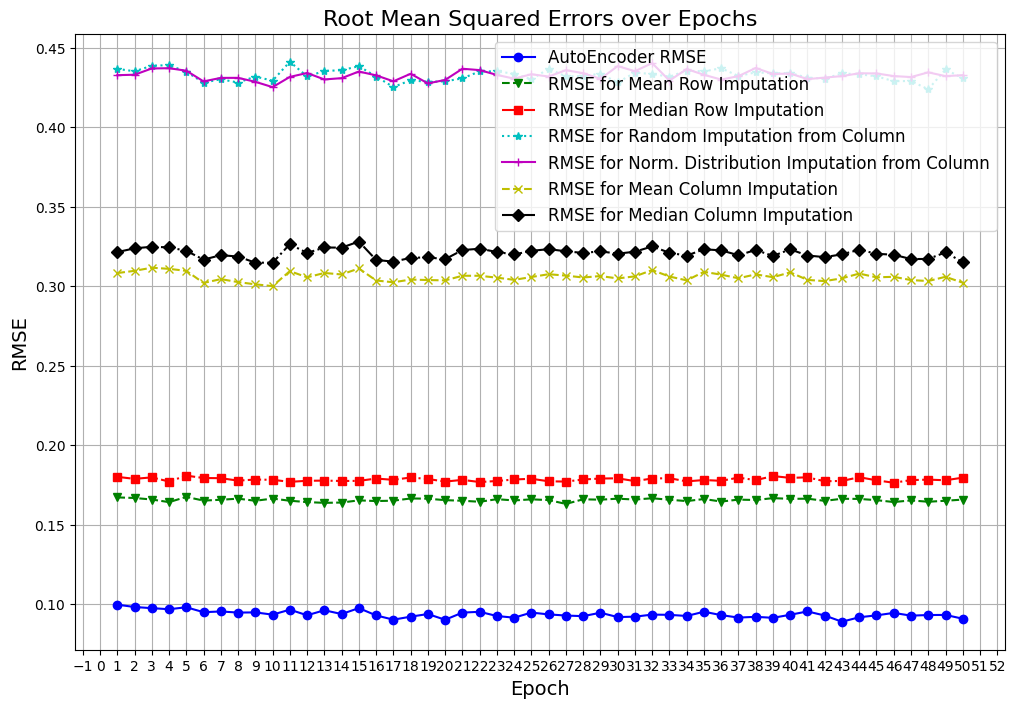

In [40]:
plt.figure(figsize=(12, 8))

# Define the same colors and styles for consistency
styles = ['-', '--', '-.', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
markers = ['o', 'v', 's', '*', '+', 'x', 'D', '1']

rmse_lines = []
rmse_labels = [
    'AutoEncoder RMSE',
    'RMSE for Mean Row Imputation',
    'RMSE for Median Row Imputation',
    'RMSE for Random Imputation from Column',
    'RMSE for Norm. Distribution Imputation from Column',
    'RMSE for Mean Column Imputation',
    'RMSE for Median Column Imputation'
]

rmse_scores = [
    test_rmse_losses,
    test_mean_rmse_losses,
    test_median_rmse_losses,
    test_randomInsertFromColumn_rmse_losses,
    test_distributionInsertFromColumn_rmse_losses,
    test_meanOfColumn_rmse_losses,
    test_medianOfColumn_rmse_losses
]

for i, rmse in enumerate(rmse_scores):
    epochs_shifted = range(1, len(rmse) + 1)
    line, = plt.plot(epochs_shifted, rmse, linestyle=styles[i % len(styles)], color=colors[i % len(colors)], marker=markers[i % len(markers)])
    rmse_lines.append(line)

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Errors over Epochs')
plt.legend(rmse_lines, rmse_labels, loc='upper right')

# Set the x-axis major ticks to an interval of 1
locator = ticker.MultipleLocator(base=1)
plt.gca().xaxis.set_major_locator(locator)

plt.grid(visible=True)
plt.show()

# Results and Analysis

In [41]:
# Libaries for Results and Analysis chapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np

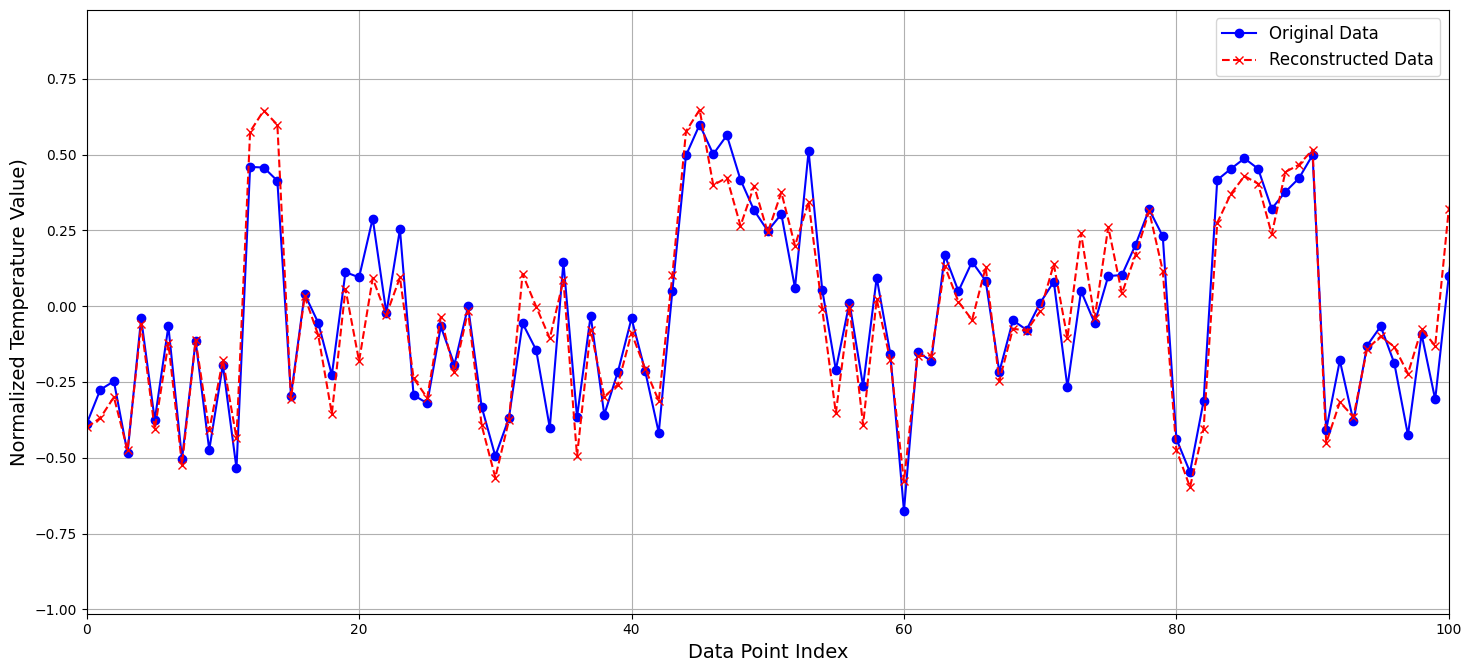

In [42]:
import matplotlib.pyplot as plt

# Convert lists to arrays (if not already)
actuals_array = np.array(all_actuals)
predictions_array = np.array(all_autoencoder_predictions)

# Define range of data points (assuming they are in order)
x_range = range(len(actuals_array))

# Plotting
plt.figure(figsize=(15, 7))

# Plot original data points
plt.plot(x_range, actuals_array, label='Original Data', color='blue', marker='o', linestyle='-')

# Plot reconstructed data points
plt.plot(x_range, predictions_array, label='Reconstructed Data', color='red', marker='x', linestyle='--')
plt.xlim(0, 100)
plt.xlabel('Data Point Index')
plt.ylabel('Normalized Temperature Value)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()

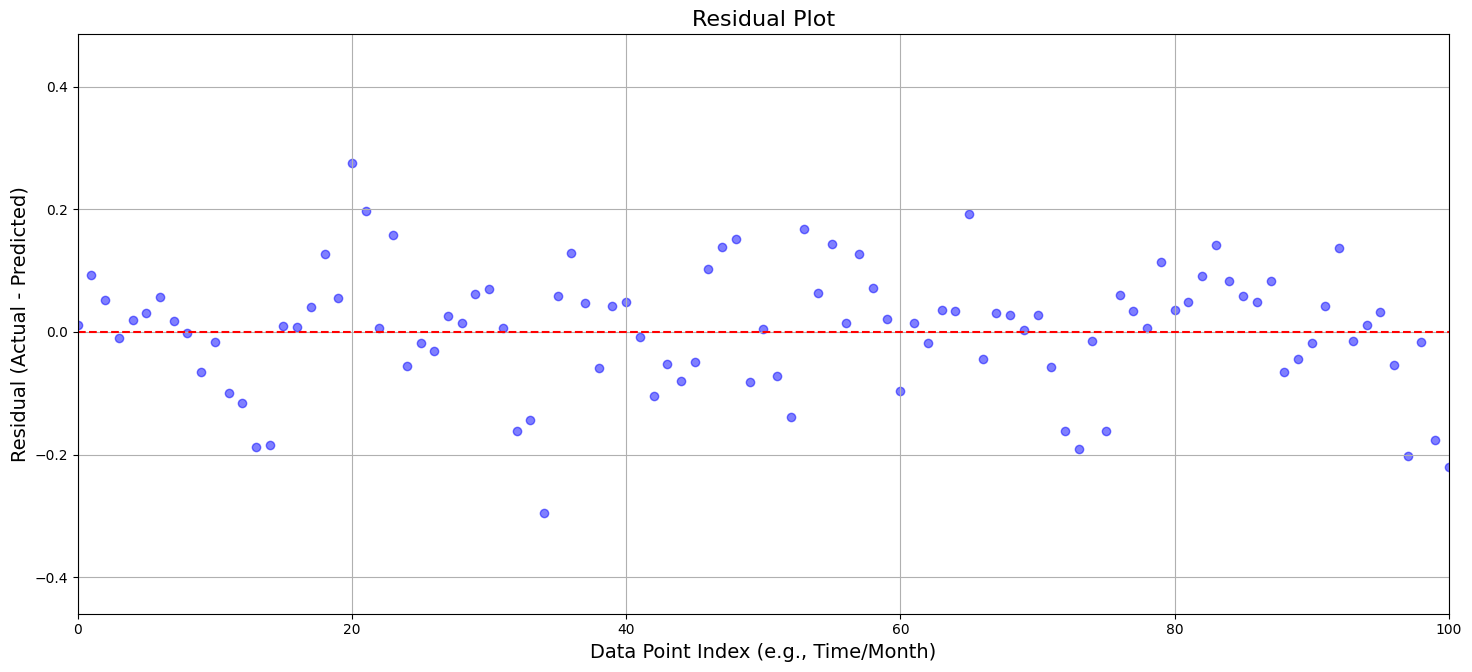

In [43]:
# Convert lists to arrays (if not already)
actuals_array = np.array(all_actuals)
predictions_array = np.array(all_autoencoder_predictions)

# Calculate residuals
residuals = actuals_array - predictions_array

# Define range of data points (assuming they are in order)
x_range = range(len(actuals_array))

# Plotting
plt.figure(figsize=(15, 7))

# Plot residuals
plt.scatter(x_range, residuals, color='blue', alpha=0.5)

# Plot a horizontal line at y=0 for reference
plt.axhline(0, color='red', linestyle='--')
plt.xlim(0, 100)
plt.xlabel('Data Point Index (e.g., Time/Month)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()

plt.show()

In [57]:
with torch.no_grad():
    # Convert the lists to numpy arrays
    actuals_array = np.array(train_actuals)
    predictions_array = np.array(train_autoencoder_predictions)

    # Compute the Pearson correlation coefficient
    correlation_coefficient = np.corrcoef(actuals_array, predictions_array)[0, 1]

    print(f"Correlation between Original and Imputed: {correlation_coefficient:.2f}")

Correlation between Original and Imputed: 0.96


In [44]:
# Convert the lists to numpy arrays
actuals_array = np.array(all_actuals)
predictions_array = np.array(all_autoencoder_predictions)

# Compute the Pearson correlation coefficient
correlation_coefficient = np.corrcoef(actuals_array, predictions_array)[0, 1]

print(f"Correlation between Original and Imputed: {correlation_coefficient:.2f}")

Correlation between Original and Imputed: 0.96


In [52]:
# Create a dictionary of metrics
data = {
    'Method': ['AutoEncoder', 'Mean Row Imputation', 'Median Row Imputation', 'Random Imputation from Column',
               'Norm. Distribution Imputation from Column', 'Mean Column Imputation', 'Median Column Imputation'],
    'MSE': [np.mean(train_losses), np.mean(train_mean_losses), np.mean(train_median_losses),
            np.mean(train_randomInsertFromColumn_losses), np.mean(train_distributionInsertFromColumn_losses),
            np.mean(train_meanOfColumn_losses), np.mean(train_medianOfColumn_losses)],
    'RMSE': [np.mean(train_rmse_losses), np.mean(train_mean_rmse_losses), np.mean(train_median_rmse_losses),
             np.mean(train_randomInsertFromColumn_rmse_losses), np.mean(train_distributionInsertFromColumn_rmse_losses),
             np.mean(train_meanOfColumn_rmse_losses), np.mean(train_medianOfColumn_rmse_losses)]
}

# Convert the dictionary to a DataFrame
df_temp = pd.DataFrame(data)

df_temp

,Method,MSE,RMSE
0,AutoEncoder,0.009170,0.095372
1,Mean Row Imputation,0.027473,0.165833
2,Median Row Imputation,0.031889,0.178731
3,Random Imputation from Column,0.187213,0.432699
4,Norm. Distribution Imputation from Column,0.187220,0.432713
5,Mean Column Imputation,0.093553,0.305891
6,Median Column Imputation,0.102727,0.320539


In [45]:
# Create a dictionary of metrics
data = {
    'Method': ['AutoEncoder', 'Mean Row Imputation', 'Median Row Imputation', 'Random Imputation from Column',
               'Norm. Distribution Imputation from Column', 'Mean Column Imputation', 'Median Column Imputation'],
    'MSE': [np.mean(test_losses), np.mean(test_mean_losses), np.mean(test_median_losses),
            np.mean(test_randomInsertFromColumn_losses), np.mean(test_distributionInsertFromColumn_losses),
            np.mean(test_meanOfColumn_losses), np.mean(test_medianOfColumn_losses)],
    'RMSE': [np.mean(test_rmse_losses), np.mean(test_mean_rmse_losses), np.mean(test_median_rmse_losses),
             np.mean(test_randomInsertFromColumn_rmse_losses), np.mean(test_distributionInsertFromColumn_rmse_losses),
             np.mean(test_meanOfColumn_rmse_losses), np.mean(test_medianOfColumn_rmse_losses)]
}

# Convert the dictionary to a DataFrame
df_temp = pd.DataFrame(data)

df_temp

,Method,MSE,RMSE
0,AutoEncoder,0.008768,0.093832
1,Mean Row Imputation,0.027392,0.165577
2,Median Row Imputation,0.031793,0.178451
3,Random Imputation from Column,0.187371,0.432851
4,Norm. Distribution Imputation from Column,0.187432,0.432883
5,Mean Column Imputation,0.093621,0.305982
6,Median Column Imputation,0.102930,0.320827


In [46]:
# Assuming df_original_pre_normalized is your data before normalization
df_min = df[df_model.columns].min()
df_max = df[df_model.columns].max()

# Create a mask to identify NaN values in the normalized data
df_final = df_model.copy()
mask = df_final.isna().astype(int).values

# Convert NaNs to 0 for processing with the model
df_masked = df_final.fillna(0)

# Convert data to tensor
data_tensor = torch.tensor(df_masked.values, dtype=torch.float32)

# Ensure the model is in evaluation mode
model.eval()

# Use the trained model to impute the values
with torch.no_grad():
    imputed_data_normalized = model(data_tensor).numpy()

# Update only the NaN values in the normalized dataframe with the imputed values
df_final.values[mask == 1] = imputed_data_normalized[mask == 1]

# Reverse the normalization on the entire df_final to get data in the original scale
df_original_scale = (((df_final + 1) * (df_max - df_min) / 2) + df_min).round(2)

df_original_scale.head()

,Belisario,Carapungo,Centro,Cotocollao,ElCamal,Guamaní,LosChillos,SanAntonio,Tumbaco
0,9.93,12.73,11.02,10.41,12.57,8.93,9.95,11.19,12.36
1,9.14,12.58,10.96,9.76,12.16,8.83,8.77,11.06,11.87
2,8.71,12.12,10.91,9.49,11.87,8.78,8.35,11.00,11.82
3,8.63,11.94,10.89,9.44,11.38,8.75,8.01,10.97,11.62
4,10.18,11.94,10.94,9.82,11.31,8.80,7.95,11.03,11.02


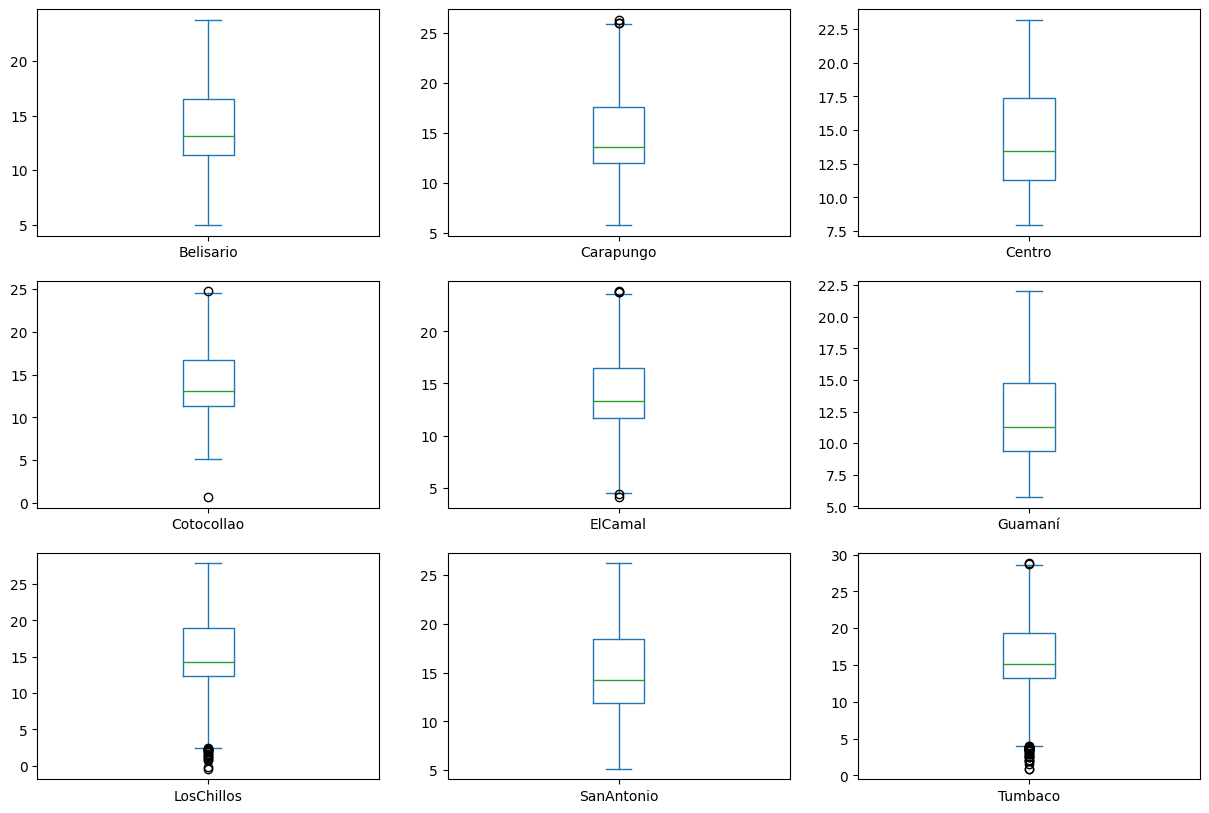

In [47]:
# Box plots for each column
df_original_scale.plot(kind='box', subplots=True, layout=(3,3), figsize=(15,10))
plt.show()

In [48]:
# Compute statistics for original data
original_stats = df[df_model.columns].describe()

# Imputed statistics
imputed_stats = df_original_scale.describe()

# Prepare list to store the concatenated Series/DataFrames
combined_stats_list = []

for col in original_stats.columns:
    combined_stats_list.append(original_stats[[col]])
    combined_stats_list.append(imputed_stats[[col]])

# Concatenate columns from the list
final_stats = (pd.concat(combined_stats_list, axis=1)).round(3)

# Rename columns for clarity
new_columns = []
for col in original_stats.columns:
    new_columns.append(f"Original_{col}")
    new_columns.append(f"Imputed_{col}")

final_stats.columns = new_columns

final_stats

,Original_Belisario,Imputed_Belisario,Original_Carapungo,Imputed_Carapungo,Original_Centro,Imputed_Centro,Original_Cotocollao,Imputed_Cotocollao,Original_ElCamal,Imputed_ElCamal,Original_Guamaní,Imputed_Guamaní,Original_LosChillos,Imputed_LosChillos,Original_SanAntonio,Imputed_SanAntonio,Original_Tumbaco,Imputed_Tumbaco
count,165199.000,167304.000,162957.000,167304.000,36131.000,167304.000,163382.000,167304.000,145020.000,167304.000,52115.000,167304.000,165715.000,167304.000,50835.000,167304.000,165139.000,167304.000
mean,13.936,13.944,14.743,14.740,14.404,14.370,13.929,13.935,13.983,14.070,12.285,12.116,15.343,15.354,15.404,15.179,16.168,16.179
std,3.201,3.203,3.425,3.418,2.980,3.238,3.203,3.195,2.998,2.989,2.816,2.974,4.369,4.367,3.344,3.576,4.128,4.127
min,4.920,4.920,5.740,5.740,7.910,7.910,0.650,0.650,4.080,4.080,5.720,5.720,-0.450,-0.450,5.120,5.120,0.870,0.870
25%,11.390,11.390,12.000,11.990,11.950,11.310,11.310,11.320,11.630,11.660,10.040,9.400,12.300,12.300,12.780,11.900,13.220,13.220
50%,13.120,13.130,13.610,13.620,13.520,13.430,13.090,13.100,13.160,13.290,11.410,11.260,14.260,14.270,14.240,14.200,15.060,15.070
75%,16.540,16.560,17.580,17.580,16.840,17.340,16.640,16.650,16.330,16.490,14.520,14.730,18.880,18.900,18.010,18.400,19.370,19.400
max,23.820,23.820,26.340,26.340,23.200,23.200,24.740,24.740,23.840,23.840,22.020,22.020,27.870,27.870,26.210,26.210,28.850,28.850


In [49]:
# deviation in the mean standard deviation
old_mean = (df[df_model.columns].mean()).mean()
new_mean = (df_original_scale[df_model.columns].mean()).mean()

print(f"The mean deviation between original and reconstructed data was {(old_mean - new_mean):.2f}°C.")

# deviation in the mean
old_mean_std = (df[df_model.columns].std()).mean()
new_mean_std = (df_original_scale[df_model.columns].std()).mean()

print(f"The mean standard deviation deviation between original and reconstructed data was {(old_mean_std - new_mean_std):.2f}°C.")

The mean deviation between original and reconstructed data was 0.03°C.
The mean standard deviation deviation between original and reconstructed data was -0.07°C.
